In [19]:
# %% 1 IMPORTS & CONFIG
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

# Parameters copied from index.html
DWELL_MS      = 800          # dwell threshold (ms)
GROW_AFTER_MS = 120          # delay before a box starts growing (ms)

CSV_FILE      = "gaze_data_all_users_long.csv"   # input
EP_OUT        = "episodes.csv"       # output episodes
MET_OUT       = "metrics.json"       # output metrics


In [20]:
# %% 2  LOAD DATA & SAMPLING RATE
s = (pd.read_csv(CSV_FILE)
       # .sort_values('timestamp')
       .assign(lasthit=lambda d: d['lasthit'].fillna('')))

# seperate to seperate dataframes for each user
users = s['user'].unique()
user_dfs = {user: s[s['user'] == user].reset_index(drop=True) for user in users}
# sort each user's data by timestamp
for user, df in user_dfs.items():
    user_dfs[user] = df.sort_values(by='timestamp').reset_index(drop=True)

# median inter-sample interval ≈ eye-tracker period
user_sampling_ms = {
       user: df['timestamp'].diff().median() for user, df in user_dfs.items()
}
user_metrics = {user: None for user in users}

SAMPLING_MS = s['timestamp'].diff().median()
SAMPLING_MS


np.float64(51.700000047683716)

In [21]:
# %% 3  DETECT DWELL EPISODES  + FLICKER TIME
for user, s in user_dfs.items():
    episodes = []
    cur_id = ''
    start_ts = prev_ts = None
    grow_on = False
    flicker_frames = 0
    fired = False

    for r in s.itertuples():
        same = (r.lasthit == cur_id) and r.lasthit != ''
        
        # -- episode boundary ----------------------------------------------------
        if not same:
            if cur_id:                       # close the previous episode
                duration = prev_ts - start_ts
                flicker_ms = flicker_frames * user_sampling_ms[user]
                saved = fired  and flicker_ms > 0
                episodes.append(dict(id=cur_id, startTS=start_ts, endTS=prev_ts,
                                    duration=duration, flicker_ms=flicker_ms,
                                    grow_on=grow_on, fired=fired, saved=saved))
            # open a new one (if we’re on an AOI)
            cur_id = r.lasthit
            start_ts = r.timestamp
            grow_on = 'g' in r.mode
            flicker_frames = 0
            fired = False
        
        # -- still inside the episode -------------------------------------------
        if cur_id:
            dt = r.timestamp - start_ts
            
            # firing moment: first time dt ≥ DWELL_MS
            if not fired and dt >= DWELL_MS:
                fired = True
            
            # count flicker frames: after grow-delay, grow hit but NOT exact hit
            if dt >= GROW_AFTER_MS and r.hitGrow == 1 and r.hitExact == 0:
                flicker_frames += 1
        
        prev_ts = r.timestamp

    # close trailing episode
    if cur_id:
        duration = prev_ts - start_ts
        flicker_ms = flicker_frames * SAMPLING_MS
        saved = fired and grow_on and flicker_ms > 0
        episodes.append(dict(id=cur_id, startTS=start_ts, endTS=prev_ts,
                            duration=duration, flicker_ms=flicker_ms,
                            grow_on=grow_on, fired=fired, saved=saved))

    ep = pd.DataFrame(episodes)
    ep.head(50)
    ep['duration'] = pd.to_numeric(ep['duration'], errors='coerce').fillna(0)
    
    mask_unsaved = ep['grow_on'] & ~ep['fired']
    user_metrics[user] = {
    "rescues"           : int(ep['saved'].sum()),
    "no_rescues"     : int((ep['fired'] & (ep['flicker_ms'].fillna(0) == 0)).sum()),
     "unsaved_grow_ms"   :#int(ep.loc[ep['grow_on'] & ~ep['fired'], 'duration'].mean() or 0),
    int(np.nan_to_num(ep.loc[mask_unsaved, 'duration'].mean(), nan=0.0)),
    "mean_flicker_ms"   : round(
        ep.loc[ep['saved'], 'flicker_ms'].mean() if ep['saved'].any() else 0,
        1
    )
    }
    #user graphs
    plt.figure(figsize=(3,3))
    plt.bar(['Rescues','No rescues'], [user_metrics[user]['rescues'],user_metrics[user]['no_rescues']])
    plt.ylabel('Count')
    plt.title('Grow-Box Rescues')
    plt.tight_layout()
    plt.savefig(f"{user}_rescues.png")
    plt.close()
    unsaved_sec  = user_metrics[user]['unsaved_grow_ms'] / 1000      # ms → s
    flicker_sec  = user_metrics[user]['mean_flicker_ms'] / 1000      # ms → s

    plt.figure(figsize=(4,3))
    plt.bar(['Unsaved grow', 'Mean flicker'],
            [unsaved_sec, flicker_sec])
    plt.ylabel('Seconds')
    plt.title('Grow-Box Durations')
    plt.tight_layout()
    plt.savefig(f"{user}_durations.png")
    plt.close()
    ep.to_csv(f"{user}_{EP_OUT}", index=False)
    with open(f"{user}_{MET_OUT}", 'w') as f: json.dump(user_metrics[user], f, indent=2)

    print(f"episodes ➜ {EP_OUT}")
    print(f"metrics  ➜ {MET_OUT}")

    


episodes ➜ episodes.csv
metrics  ➜ metrics.json
episodes ➜ episodes.csv
metrics  ➜ metrics.json
episodes ➜ episodes.csv
metrics  ➜ metrics.json
episodes ➜ episodes.csv
metrics  ➜ metrics.json
episodes ➜ episodes.csv
metrics  ➜ metrics.json
episodes ➜ episodes.csv
metrics  ➜ metrics.json
episodes ➜ episodes.csv
metrics  ➜ metrics.json
episodes ➜ episodes.csv
metrics  ➜ metrics.json


In [22]:
# %% 4  METRICS
metrics = {
    "rescues"           : int(ep['saved'].sum()),
    "no_rescues"     : int((ep['fired'] & (ep['flicker_ms'].fillna(0) == 0)).sum()),
    "unsaved_grow_ms"   : int(ep.loc[ep['grow_on'] & ~ep['fired'], 'duration'].mean() or 0),
    "mean_flicker_ms"   : round(
        ep.loc[ep['saved'], 'flicker_ms'].mean() if ep['saved'].any() else 0,
        1
    )
}
metrics


ValueError: cannot convert float NaN to integer

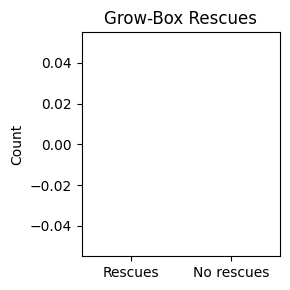

In [ ]:
# %% 5  VISUALISE
# %% 5A  VISUALISE — rescues (count)
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
plt.bar(['Rescues','No rescues'], [metrics['rescues'],metrics['no_rescues']])
plt.ylabel('Count')
plt.title('Grow-Box Rescues')
plt.tight_layout()
plt.show()


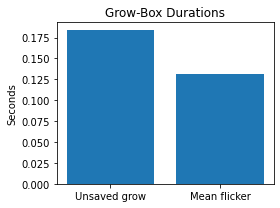

In [ ]:
# %% 5B  VISUALISE — durations (seconds, consistent units)
unsaved_sec  = metrics['unsaved_grow_ms'] / 1000      # ms → s
flicker_sec  = metrics['mean_flicker_ms'] / 1000      # ms → s

plt.figure(figsize=(4,3))
plt.bar(['Unsaved grow', 'Mean flicker'],
        [unsaved_sec, flicker_sec])
plt.ylabel('Seconds')
plt.title('Grow-Box Durations')
plt.tight_layout()
plt.show()

In [ ]:
# %% 6  SAVE OUTPUTS
ep.to_csv(EP_OUT, index=False)
with open(MET_OUT, 'w') as f: json.dump(metrics, f, indent=2)

print(f"episodes ➜ {EP_OUT}")
print(f"metrics  ➜ {MET_OUT}")


episodes ➜ episodes.csv
metrics  ➜ metrics.json
